# Development Notebook
## 1. Classes for tank properties

* [Current Work](#WIP)

In [1]:
from dataclasses import dataclass
from typing import Union

import matplotlib.pyplot as plt
import numpy as np

In [2]:
T_d = 194  # mm
T_br = T_d / 2  # mm
T_bz = 148  # mm

E_zr1 = 50  # mm
E_zr2 = 100  # mm

In [3]:
@dataclass
class TankProperties32x2:
    T_d: int = 194
    T_r: int = 97
    T_bx: tuple = (-T_d / 2, T_d / 2)
    T_by: tuple = (-T_d / 2, T_d / 2)
    T_bz: tuple = (0, 148)
    E_zr1: int = 50
    E_zr2: int = 100
    n_el: int = 64


@dataclass
class BallObjectProperties:
    x: Union[int, float]  # mm
    y: Union[int, float]  # mm
    z: Union[int, float]  # mm
    r: Union[int, float]  # mm
    material: str

In [4]:
TankProperties32x2()

TankProperties32x2(T_d=194, T_r=97, T_bx=(-97.0, 97.0), T_by=(-97.0, 97.0), T_bz=(0, 148), E_zr1=50, E_zr2=100, n_el=64)

## 2. Functions to get the hitbox

In [5]:
from src.classes import BallObjectProperties, TankProperties32x2

In [6]:
tank = TankProperties32x2()
tank

TankProperties32x2(T_d=194, T_r=97, T_bx=(-97.0, 97.0), T_by=(-97.0, 97.0), T_bz=(0, 148), E_zr1=50, E_zr2=100, n_el=64)

In [7]:
ball = BallObjectProperties(0, 0, 0, 20, None)
ball

BallObjectProperties(x=0, y=0, z=0, r=20, material=None)

In [8]:
@dataclass
class HitBox:
    r_min: Union[int, float]
    r_max: Union[int, float]
    x_min: Union[int, float]
    x_max: Union[int, float]
    y_min: Union[int, float]
    y_max: Union[int, float]
    z_min: Union[int, float]
    z_max: Union[int, float]

In [9]:
def compute_hitbox(
    tank: TankProperties32x2,
    ball: BallObjectProperties,
    safety_tolerance: Union[int, float] = 5.0,  # mm
) -> HitBox:
    hitbox = HitBox(
        r_min=0,
        r_max=tank.T_bx[1] - ball.r - safety_tolerance,
        x_min=tank.T_bx[0] + ball.r + safety_tolerance,
        x_max=tank.T_bx[1] - ball.r - safety_tolerance,
        y_min=tank.T_by[0] + ball.r + safety_tolerance,
        y_max=tank.T_by[1] - ball.r - safety_tolerance,
        z_min=tank.T_bz[0] + ball.r + safety_tolerance,
        z_max=tank.T_bz[1] - ball.r - safety_tolerance,
    )
    return hitbox

In [10]:
compute_hitbox(tank, ball)

HitBox(r_min=0, r_max=72.0, x_min=-72.0, x_max=72.0, y_min=-72.0, y_max=72.0, z_min=25.0, z_max=123.0)

## 3. Functions for measurement steps

In [11]:
from typing import Union

import matplotlib.pyplot as plt
import numpy as np

from src.classes import BallObjectProperties, HitBox, TankProperties32x2
from src.functions import compute_hitbox

In [12]:
tank = TankProperties32x2()
ball = BallObjectProperties(0, 0, 0, 20, None)

In [13]:
hitbox = compute_hitbox(tank, ball)

In [14]:
hitbox.r_max = 50

In [15]:
def create_meas_coordinates(
    hitbox: HitBox, x_points: int, y_points: int, z_points: int
) -> np.ndarray:
    x = np.linspace(hitbox.x_min, hitbox.x_max, x_points)
    y = np.linspace(hitbox.y_min, hitbox.y_max, y_points)
    z = np.linspace(hitbox.z_min, hitbox.z_max, z_points)

    xx, yy, zz = np.meshgrid(x, y, z)

    distances = np.sqrt(xx**2 + yy**2)
    mask = distances <= hitbox.r_max

    x_flat = xx[mask].flatten()
    y_flat = yy[mask].flatten()
    z_flat = zz[mask].flatten()

    print(f"{x_points*y_points*z_points} measurement points were created.")
    return np.vstack((x_flat, y_flat, z_flat)).T

In [16]:
meas_coords = create_meas_coordinates(hitbox, x_points=10, y_points=10, z_points=10)

1000 measurement points were created.


## 4. Test hitbox and visualization

In [17]:
from typing import Union

import matplotlib.pyplot as plt
import numpy as np

from src.classes import BallObjectProperties, HitBox, TankProperties32x2
from src.functions import compute_hitbox, create_meas_coordinates

In [18]:
tank = TankProperties32x2()
ball = BallObjectProperties(x=0, y=0, z=0, r=30, material=None)
hitbox = compute_hitbox(tank, ball)

In [19]:
print(tank)
print(ball)
print(hitbox)

TankProperties32x2(T_d=194, T_r=97, T_bx=(-97.0, 97.0), T_by=(-97.0, 97.0), T_bz=(0, 148), E_zr1=50, E_zr2=100, n_el=64)
BallObjectProperties(x=0, y=0, z=0, r=30, material=None)
HitBox(r_min=0, r_max=62.0, x_min=-62.0, x_max=62.0, y_min=-62.0, y_max=62.0, z_min=35.0, z_max=113.0)


In [21]:
meas_coords = create_meas_coordinates(hitbox, x_pts=10, y_pts=15, z_pts=10)

HitBox(x_pts,y_pts,z_pts) leads to 940 available points.
So 940 points will be measured.


In [22]:
def plot_meas_coords(
    tank: TankProperties32x2,
    meas_coords: np.ndarray,
    p_select: Union[None, int] = None,
    elev: int = 20,
    azim: int = 10,
) -> None:
    x_flat = meas_coords[:, 0]
    y_flat = meas_coords[:, 1]
    z_flat = meas_coords[:, 2]

    zyl_pnts = 50
    theta = np.linspace(0, 2 * np.pi, zyl_pnts)
    z = np.linspace(tank.T_bz[0], tank.T_bz[1], zyl_pnts)
    Z, Theta = np.meshgrid(z, theta)
    X = tank.T_r * np.cos(Theta)
    Y = tank.T_r * np.sin(Theta)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    # phantom-tank border
    ax.plot_surface(X, Y, Z, color="C7", alpha=0.2)

    if p_select == None:
        ax.scatter(x_flat, y_flat, z_flat, c="b", marker="o", alpha=0.2)
    else:
        ax.scatter(x_flat, y_flat, z_flat, c="b", marker="o", alpha=0.2)
        ax.scatter(
            meas_coords[p_select, 0],
            meas_coords[p_select, 1],
            meas_coords[p_select, 2],
            c="r",
            marker="o",
            # s=25,
        )
    ax.set_xlim([tank.T_bx[0], tank.T_bx[1]])
    ax.set_ylim([tank.T_by[0], tank.T_by[1]])
    ax.set_zlim([tank.T_bz[0], tank.T_bz[1]])

    ax.set_xlabel("x pos [mm]")
    ax.set_ylabel("y pos [mm]")
    ax.set_zlabel("z pos [mm]")
    ax.view_init(elev=elev, azim=azim)
    plt.tight_layout()
    plt.show()


def plot_meas_coords_wball(
    tank: TankProperties32x2,
    meas_coords: np.ndarray,
    ball: BallObjectProperties,
    p_select: int = 0,
    elev: int = 20,
    azim: int = 10,
) -> None:
    x_flat = meas_coords[:, 0]
    y_flat = meas_coords[:, 1]
    z_flat = meas_coords[:, 2]

    zyl_pnts = 50
    theta = np.linspace(0, 2 * np.pi, zyl_pnts)
    z = np.linspace(tank.T_bz[0], tank.T_bz[1], zyl_pnts)
    Z, Theta = np.meshgrid(z, theta)
    X = tank.T_r * np.cos(Theta)
    Y = tank.T_r * np.sin(Theta)

    bwl_pts = 10
    u = np.linspace(0, 2 * np.pi, bwl_pts)
    v = np.linspace(0, np.pi, bwl_pts)
    x_c = meas_coords[p_select, 0] + ball.r * np.outer(np.cos(u), np.sin(v))
    y_c = meas_coords[p_select, 1] + ball.r * np.outer(np.sin(u), np.sin(v))
    z_c = meas_coords[p_select, 2] + ball.r * np.outer(
        np.ones(np.size(u)), np.cos(v)
    )

    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    # phantom-tank border
    ax.plot_surface(X, Y, Z, color="C7", alpha=0.2)
    # selected bowl
    ax.plot_surface(x_c, y_c, z_c, color="C1", alpha=0.3)

    ax.scatter(x_flat, y_flat, z_flat, c="b", marker="o", alpha=0.1)
    ax.scatter(
        meas_coords[p_select, 0],
        meas_coords[p_select, 1],
        meas_coords[p_select, 2],
        c="r",
        marker="o",
        # s=25,
    )
    ax.set_xlim([tank.T_bx[0], tank.T_bx[1]])
    ax.set_ylim([tank.T_by[0], tank.T_by[1]])
    ax.set_zlim([tank.T_bz[0], tank.T_bz[1]])

    ax.set_xlabel("x pos [mm]")
    ax.set_ylabel("y pos [mm]")
    ax.set_zlabel("z pos [mm]")
    ax.view_init(elev=elev, azim=azim)
    plt.tight_layout()
    plt.show()

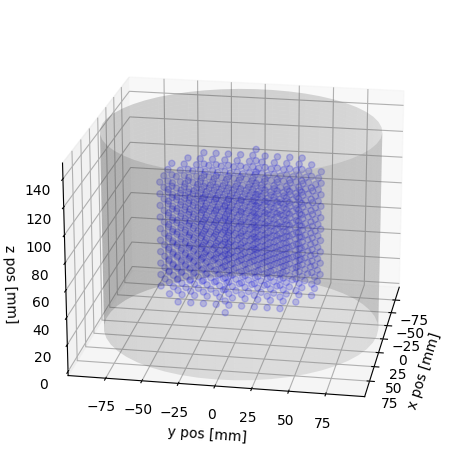

In [23]:
plot_meas_coords(tank=tank, meas_coords=meas_coords, p_select=None, elev=20,azim=10)

<a id="WIP"></a>
## 5. Testing the current state

In [1]:
from src.classes import BallObjectProperties, HitBox, TankProperties32x2
from src.functions import compute_hitbox, create_meas_coordinates, print_coordinates_props
from src.visualization import plot_meas_coords, plot_meas_coords_wball

In [2]:
tank = TankProperties32x2()
ball = BallObjectProperties(x=0, y=0, z=0, r=20, material=None)
hitbox = compute_hitbox(tank, ball, safety_tolerance=0)

In [3]:
print(tank)
print(ball)
print(hitbox)

TankProperties32x2(T_d=194, T_r=97, T_bx=(-97.0, 97.0), T_by=(-97.0, 97.0), T_bz=(0, 148), E_zr1=50, E_zr2=100, n_el=64)
BallObjectProperties(x=0, y=0, z=0, r=20, material=None)
HitBox(r_min=0, r_max=77.0, x_min=-77.0, x_max=77.0, y_min=-77.0, y_max=77.0, z_min=20, z_max=128)


In [4]:
coordinates = create_meas_coordinates(hitbox, x_pts=20, y_pts=20, z_pts=10)

HitBox(x_pts,y_pts,z_pts) leads to 2760 available points.
So 2760 points will be measured.


In [5]:
print_coordinates_props(coordinates)

Properties of the computed coordinates
--------------------------------------
min:-68.89	max: 68.89
min:-68.89	max: 68.89
min:20.00	max: 128.00

shape (2760, 3)


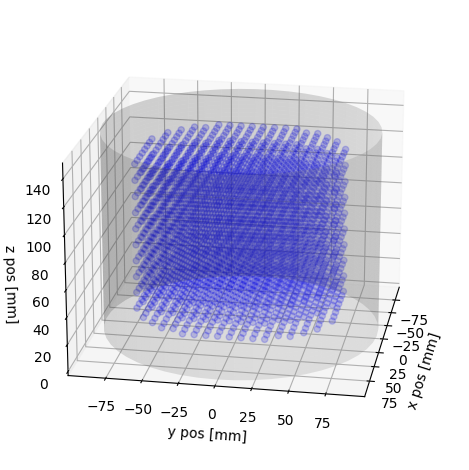

In [10]:
plot_meas_coords(tank=tank, meas_coords=coordinates, p_select=None)

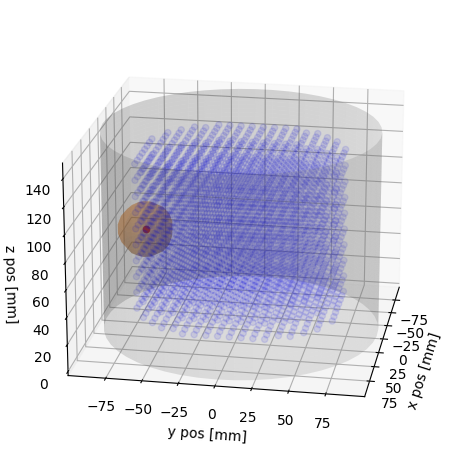

In [7]:
plot_meas_coords_wball(tank=tank, meas_coords=coordinates, ball=ball, p_select=34)